# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
from lakemodel_function import lake_problem
from ema_workbench import Model, RealParameter, ScalarOutcome
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams['lines.markersize'] = 3
plt.style.use('seaborn-white')

In [2]:
# number of levers in the lake_model
n_levers = 100

model = Model('LakeProblem', function=lake_problem)

# specify uncertainties
model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('delta', 0.93, 0.99)]

# specify levers
model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(n_levers)]

# specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

In [3]:
# define experiments by combinations of policies and scenarios
# instead of now specifiying a specific policy, we let the ema workbnch select 4 random policies

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    experiments_policy, outcomes_policy  = evaluator.perform_experiments(scenarios=1000, policies=10)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
# use .drop to get rid of the columns with the values for the levers
experiments_policy.drop(columns=[f"l{i}" for i in range(n_levers)], inplace=True)

In [5]:
experiments_policy

,b,delta,mean,q,stdev,scenario,policy,model
0,0.153696,0.943272,0.037251,3.769317,0.001369,0,0,LakeProblem
1,0.241484,0.951607,0.028744,2.837239,0.003948,1,0,LakeProblem
2,0.362877,0.942326,0.024900,3.683134,0.003292,2,0,LakeProblem
3,0.160707,0.943595,0.019520,3.642529,0.003927,3,0,LakeProblem
4,0.167578,0.964713,0.016597,2.932070,0.004707,4,0,LakeProblem
...,...,...,...,...,...,...,...,...
9995,0.232994,0.930378,0.046653,2.802543,0.001011,995,9,LakeProblem
9996,0.395026,0.950595,0.035228,3.160068,0.002604,996,9,LakeProblem
9997,0.261087,0.971329,0.041554,3.541419,0.003226,997,9,LakeProblem
9998,0.131935,0.942413,0.030269,4.072683,0.001518,998,9,LakeProblem


In [6]:
# We select the top 10% of worst outcomes for reliability and use PRIM to determine the range of values that fit that selection
x = experiments_policy
y = outcomes_policy['reliability'] < np.percentile(outcomes_policy['reliability'], 10)

# We select the value for peel_alpha by trial and error such that we get all the dimensions as output as well as a threshold above 0.8
prim_alg = prim.Prim(x,y, threshold=0.8, peel_alpha=0.0285)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 854 cases of interest
[MainProcess/INFO] mean: 0.9092664092664092, mass: 0.0518, coverage: 0.5515222482435597, density: 0.9092664092664092 restricted_dimensions: 5


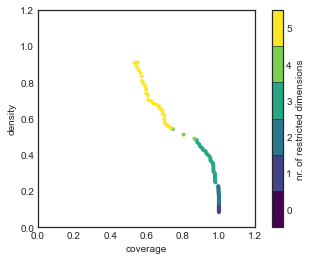

In [7]:
box1.show_tradeoff()
plt.show()

coverage    0.576112
density     0.807882
id                82
mass          0.0609
mean        0.807882
res_dim            5
Name: 82, dtype: object

                       box 82                         \
                          min                    max   
q                    2.001239               2.590783   
b                    0.100055               0.245611   
policy  {0, 2, 3, 4, 6, 8, 9}  {0, 2, 3, 4, 6, 8, 9}   
stdev                0.001226               0.004996   
mean                 0.010539               0.049962   

                                         
                              qp values  
q        [-1.0, 7.900035557789658e-191]  
b       [-1.0, 4.1956938729296404e-116]  
policy   [1.8596498085053146e-12, -1.0]  
stdev       [0.11508023435199552, -1.0]  
mean        [0.39397486861271064, -1.0]  



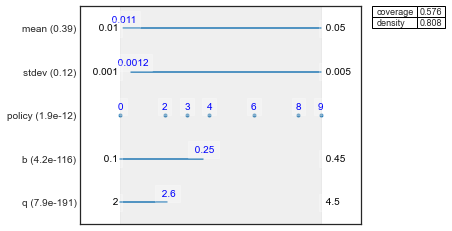

In [17]:
# We select point 82 by trial and error until we obtain a density above 0.80
prim_selection = 82
box1.inspect(prim_selection)
box1.inspect(prim_selection, style='graph')
plt.show()

Based on the above visualization of the outcomes, we can observe that two model variables (b and q) and the policies have a statistical significant relation on the scenarios of interest, i.e. the cases where reliability is among the worst 10%. 

C:\Users\Willy\Anaconda3\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:404: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


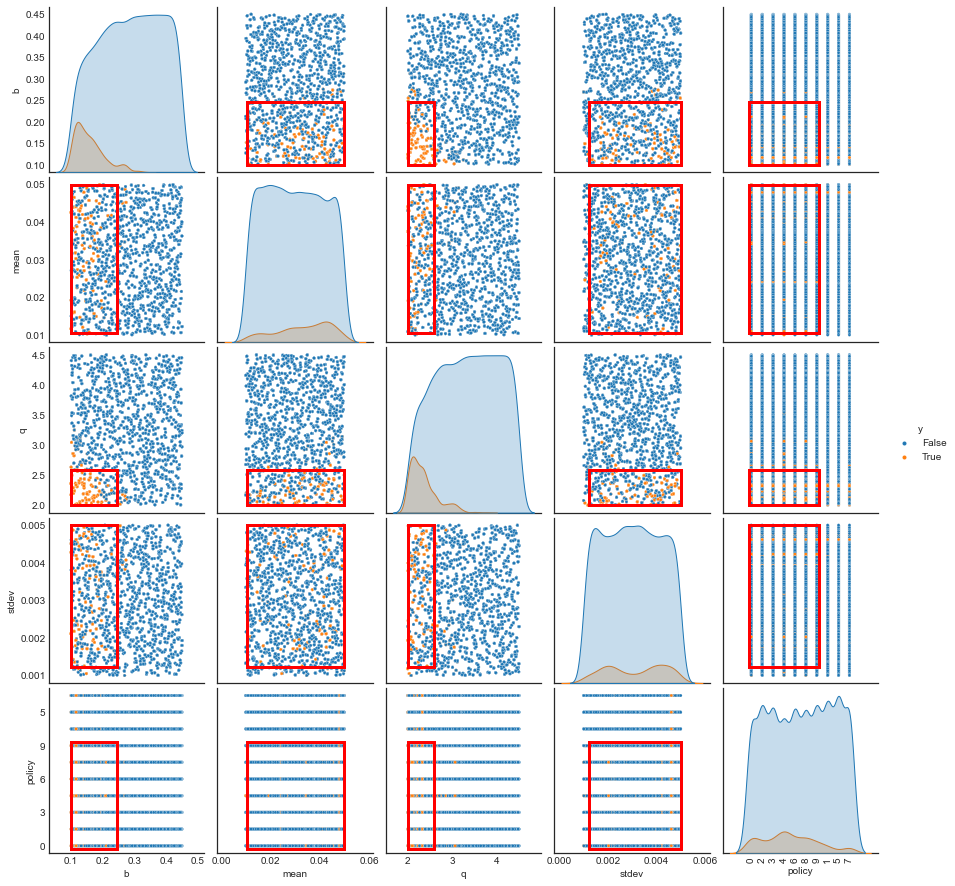

In [18]:
box1.show_pairs_scatter(prim_selection)
plt.show()

The above plot visually confirms the statistics previously obtained. We can see that especially b and q combined allow for a strict bounded box to be found b the prim algorithm. Given the selected threshold for the algorithm, we can see how some of the orange dots are outside of the boundary box. This suggests how the boundaries are indicative and not normative.

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category


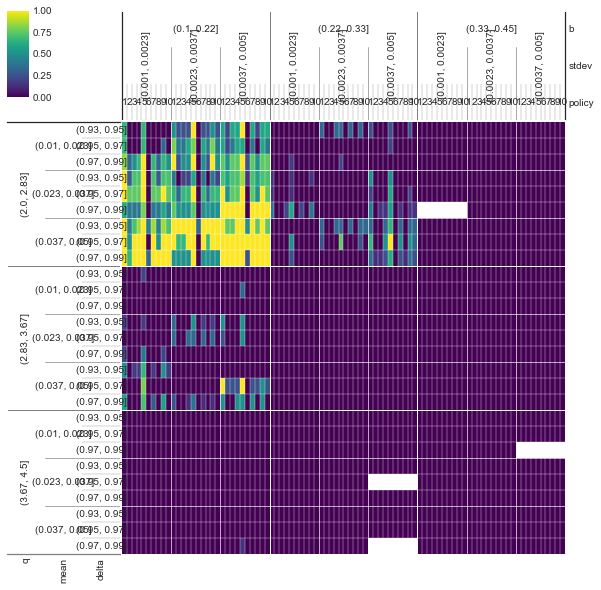

In [10]:
dimensional_stacking.create_pivot_plot(x,y, 3, nbins=3, bin_labels=True)
plt.show()

The best feature scores can be upserved in the upper-left quadrat, which relate to a interval for q of 2.0-2.83 and an interval for b of 0.1-0.22. We can see that these intervals relate to the boxes that were made from the prim, see the table below. There are also a few high feature scores observable outside the upper-left quadrant, which correspond to the points outside the boxes drawn by the prim algorithm. 


|     |                   min    |                max   |
|-----|-----|-----|
|q      |              2.001239     |          2.590783   |
|b      |              0.100055    |          0.245611   |
|policy | {0, 2, 3, 4, 6, 8, 9}  |{0, 2, 3, 4, 6, 8, 9}   |
|stdev  |              0.001226     |          0.004996   |
|mean   |              0.010539    |           0.049962  |


 We can also see how some of the cells are empty. This means that none of the samples fit those ranges of values. In order to fully analyse the ranges, we should increase the number of experiments.